In [11]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import class_weight


# Define batch specifications
batch_size = 4
img_height = 128
img_width = 128
num_frames = 32  # Number of frames in each video clip




In [12]:
# Function to load video clips
def load_video_clips(directory, num_frames=32, img_height=128, img_width=128):
    clips = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if not os.path.isdir(label_dir):
            continue  # Skip non-directory files
        for clip_folder in os.listdir(label_dir):
            clip_path = os.path.join(label_dir, clip_folder)
            if not os.path.isdir(clip_path):
                continue  # Skip non-directory files
            frames = []
            frame_files = sorted(os.listdir(clip_path))
            if len(frame_files) < num_frames:
                continue  # Skip clips with fewer frames than required
            for frame_name in frame_files[:num_frames]:  # Load only the first `num_frames` frames
                frame_path = os.path.join(clip_path, frame_name)
                frame = load_img(frame_path, target_size=(img_height, img_width))
                frame = img_to_array(frame) / 255.0  # Normalize to [0, 1]
                frames.append(frame)
            clips.append(np.array(frames))
            labels.append(0 if label == 'non_accident' else 1)
    return np.array(clips), np.array(labels)

# Load training, validation, and testing data
X_train, y_train = load_video_clips('data/train')
X_val, y_val = load_video_clips('data/val')
X_test, y_test = load_video_clips('data/test')

In [13]:
print(f"Number of training clips: {len(X_train)}")
print(f"Number of validation clips: {len(X_val)}")
print(f"Number of testing clips: {len(X_test)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Number of training clips: 373
Number of validation clips: 79
Number of testing clips: 82
X_train shape: (373, 32, 128, 128, 3)
y_train shape: (373,)
X_val shape: (79, 32, 128, 128, 3)
y_val shape: (79,)
X_test shape: (82, 32, 128, 128, 3)
y_test shape: (82,)


In [14]:
# Define the improved model function
def create_improved_model():
    model = tf.keras.models.Sequential([
        layers.Input(shape=(num_frames, img_height, img_width, 3)),
        
        # Temporal modeling
        layers.TimeDistributed(layers.Conv2D(32, (3,3), activation='relu')),
        layers.TimeDistributed(layers.MaxPooling2D(2,2)),
        layers.TimeDistributed(layers.BatchNormalization()),
        
        layers.TimeDistributed(layers.Conv2D(64, (3,3), activation='relu')),
        layers.TimeDistributed(layers.MaxPooling2D(2,2)),
        layers.TimeDistributed(layers.BatchNormalization()),
        
        # Spatial features
        layers.Conv3D(128, (3,3,3), activation='relu', padding='same'),
        layers.MaxPooling3D((2,2,2)),
        layers.BatchNormalization(),
        
        layers.GlobalAveragePooling3D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', 
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )
    return model


In [15]:
# Analyze class distribution
print("\nClass distribution:")
print(f"Train - Non-accident: {sum(y_train==0)}, Accident: {sum(y_train==1)}")
print(f"Val - Non-accident: {sum(y_val==0)}, Accident: {sum(y_val==1)}")
print(f"Test - Non-accident: {sum(y_test==0)}, Accident: {sum(y_test==1)}")

# Add class weights to handle imbalance
class_weights = class_weight.compute_class_weight('balanced',
                                                classes=np.unique(y_train),
                                                y=y_train)
class_weights = dict(enumerate(class_weights))
print(f"\nClass weights: {class_weights}")



Class distribution:
Train - Non-accident: 165, Accident: 208
Val - Non-accident: 35, Accident: 44
Test - Non-accident: 36, Accident: 46

Class weights: {0: 1.1303030303030304, 1: 0.8966346153846154}


In [16]:
# Define callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3),
    ModelCheckpoint("best_model.h5", save_best_only=True)
]


In [17]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)


In [18]:
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
y_train = y_train.astype('int32')
y_val = y_val.astype('int32')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_3d_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

batch_size = 4 # Set as per memory capacity

# Create and train improved model
improved_model = create_improved_model()
improved_model.summary()

history = improved_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=batch_size,
    class_weight=class_weights,
    callbacks=callbacks
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_6              │ (None, 32, 126, 126,   │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 32, 63, 63, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 32, 63, 63, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 32, 61, 61, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 32, 30, 30, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 32, 30, 30, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 32, 30, 30,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 16, 15, 15,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 15, 15,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 274,881 (1.05 MB)

 Trainable params: 274,433 (1.05 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4985 - loss: 0.7027 - precision: 0.5403 - recall: 0.4714

94/94 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.4984 - loss: 0.7029 - precision: 0.5403 - recall: 0.4714 - val_accuracy: 0.5316 - val_loss: 0.6825 - val_precision: 0.5538 - val_recall: 0.8182 - learning_rate: 1.0000e-04
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5549 - loss: 0.7213 - precision: 0.5952 - recall: 0.5459

94/94 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.5550 - loss: 0.7211 - precision: 0.5956 - recall: 0.5457 - val_accuracy: 0.5949 - val_loss: 0.6621 - val_precision: 0.6250 - val_recall: 0.6818 - learning_rate: 1.0000e-04
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6014 - loss: 0.6620 - precision: 0.6345 - recall: 0.6062

94/94 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.6010 - loss: 0.6622 - precision: 0.6343 - recall: 0.6057 - val_accuracy: 0.6076 - val_loss: 0.6429 - val_precision: 0.6512 - val_recall: 0.6364 - learning_rate: 1.0000e-04
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5872 - loss: 0.6750 - precision: 0.6649 - recall: 0.5556

94/94 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.5869 - loss: 0.6752 - precision: 0.6645 - recall: 0.5552 - val_accuracy: 0.6582 - val_loss: 0.6411 - val_precision: 0.6889 - val_recall: 0.7045 - learning_rate: 1.0000e-04
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.5196 - loss: 0.6989 - precision: 0.5850 - recall: 0.4865 - val_accuracy: 0.6203 - val_loss: 0.6527 - val_precision: 0.6667 - val_recall: 0.6364 - learning_rate: 1.0000e-04
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.5966 - loss: 0.6714 - precision: 0.6504 - recall: 0.5619 - val_accuracy: 0.6456 - val_loss: 0.6502 - val_precision: 0.6739 - val_recall: 0.7045 - learning_rate: 1.0000e-04
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5983 - loss: 0.6573 - precision: 0.6523 - recall: 0.5919

94/94 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.5985 - loss: 0.6574 - precision: 0.6524 - recall: 0.5923 - val_accuracy: 0.6329 - val_loss: 0.6296 - val_precision: 0.7778 - val_recall: 0.4773 - learning_rate: 1.0000e-04
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.5802 - loss: 0.6822 - precision: 0.6717 - recall: 0.5806 - val_accuracy: 0.5949 - val_loss: 0.6435 - val_precision: 0.6111 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.5393 - loss: 0.6799 - precision: 0.5992 - recall: 0.5117 - val_accuracy: 0.5570 - val_loss: 0.6493 - val_precision: 0.5849 - val_recall: 0.7045 - learning_rate: 1.0000e-04
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6339 - loss: 0.6409 - precision: 0.6866 - recall: 0.6624

94/94 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.6336 - loss: 0.6411 - precision: 0.6862 - recall: 0.6620 - val_accuracy: 0.6329 - val_loss: 0.6169 - val_precision: 0.6829 - val_recall: 0.6364 - learning_rate: 1.0000e-04


In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import json



Evaluating on test set...

Starting enhanced evaluation...
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.6232 - loss: 0.6445 - precision: 0.9046 - recall: 0.6399

Enhanced Evaluation:
Test Loss: 0.6360
Test Accuracy: 0.6463
Precision/Recall metrics not found in model

Generating predictions...
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step

Classification Report:
              precision    recall  f1-score   support

non_accident       0.61      0.56      0.58        36
    accident       0.67      0.72      0.69        46

    accuracy                           0.65        82
   macro avg       0.64      0.64      0.64        82
weighted avg       0.64      0.65      0.64        82



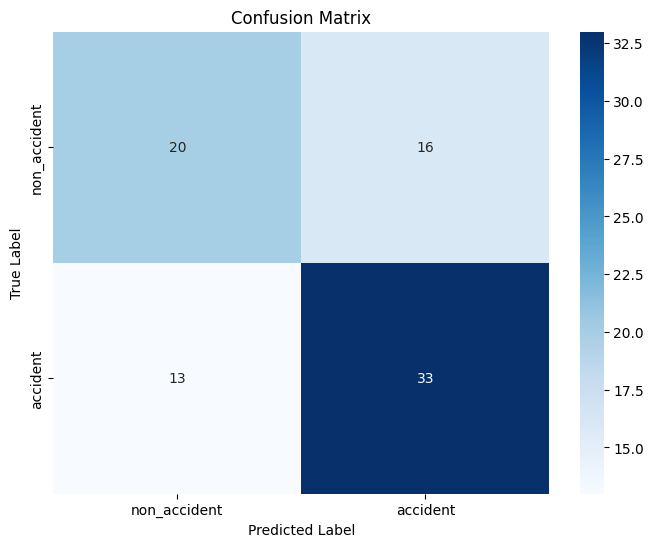

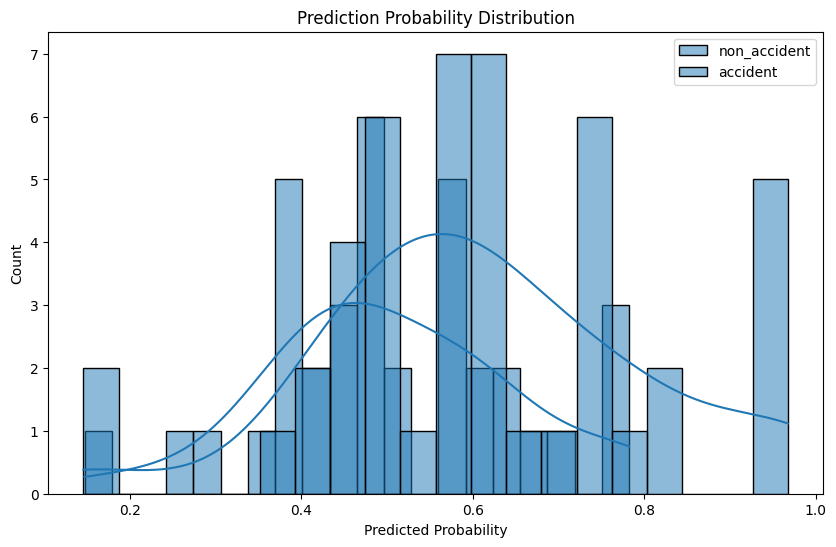

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def enhanced_evaluation(model, X_test, y_test, batch_size=8):
    # Evaluate
    print("\nStarting enhanced evaluation...")
    results = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
    
    print("\nEnhanced Evaluation:")
    print(f"Test Loss: {results[0]:.4f}")
    print(f"Test Accuracy: {results[1]:.4f}")
    
    # Handle case where metrics might be in different positions
    metric_names = [m.name for m in model.metrics]
    try:
        precision_idx = metric_names.index('precision')
        recall_idx = metric_names.index('recall')
        print(f"Test Precision: {results[precision_idx+1]:.4f}")  # +1 because loss is first
        print(f"Test Recall: {results[recall_idx+1]:.4f}")
    except ValueError:
        print("Precision/Recall metrics not found in model")
    
    # Predictions
    print("\nGenerating predictions...")
    y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)
    y_pred_classes = (y_pred > 0.5).astype("int32")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes, 
                              target_names=['non_accident', 'accident'],
                              zero_division=0))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['non_accident', 'accident'],
               yticklabels=['non_accident', 'accident'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Plot probability distributions
    plt.figure(figsize=(10,6))
    sns.histplot(y_pred[y_test==0], color='blue', label='non_accident', kde=True, bins=20)
    sns.histplot(y_pred[y_test==1], color='red', label='accident', kde=True, bins=20)
    plt.title('Prediction Probability Distribution')
    plt.xlabel('Predicted Probability')
    plt.legend()
    plt.show()

# After training your model, call it like this:
print("\nEvaluating on test set...")
enhanced_evaluation(improved_model, X_test, y_test, batch_size=batch_size)

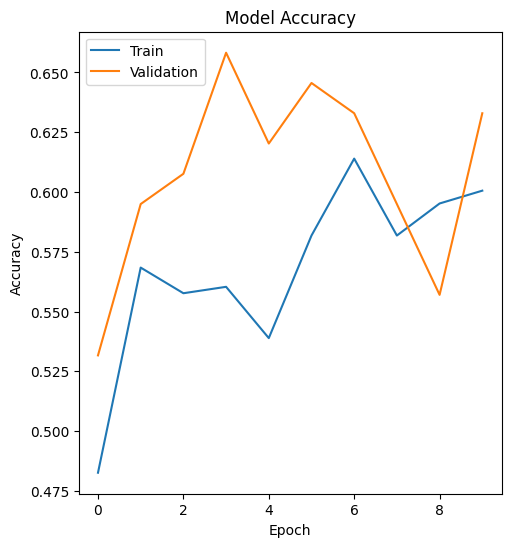

In [22]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


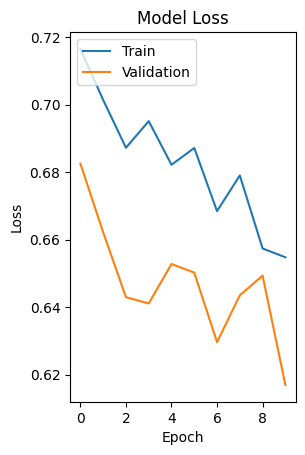

In [23]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('training_history.png')
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 788ms/step


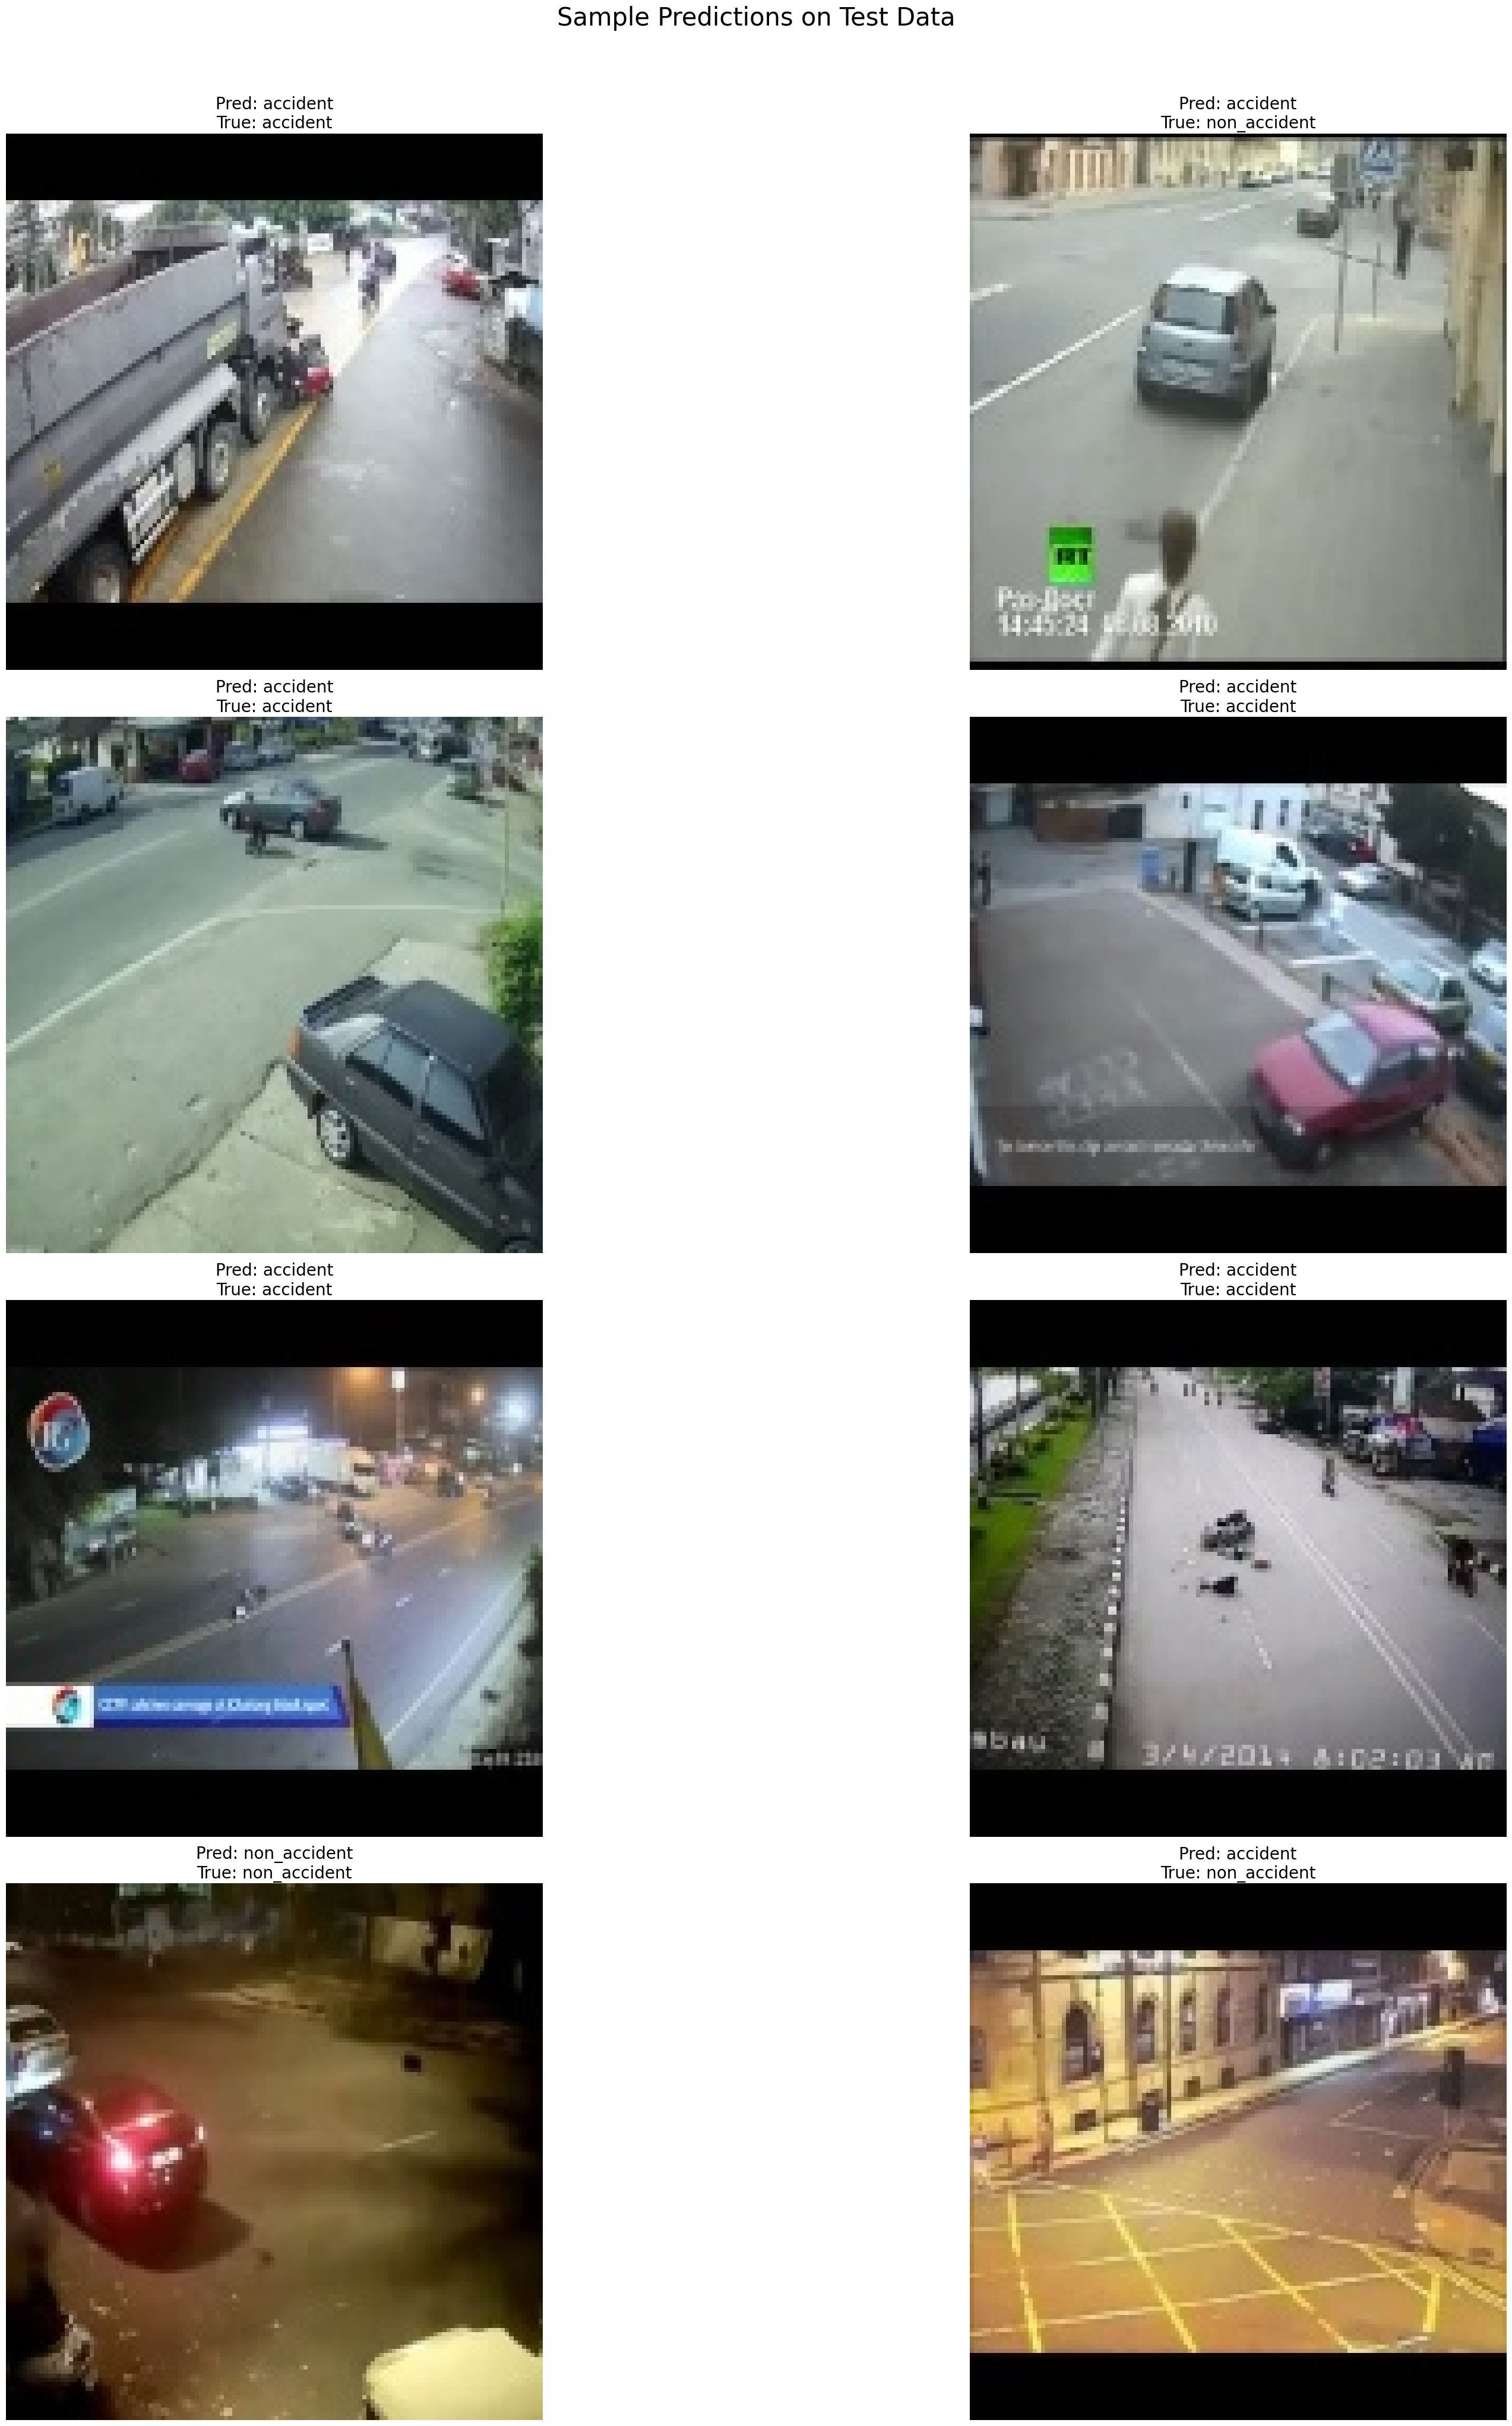


Classification Report:
              precision    recall  f1-score   support

non_accident       0.61      0.56      0.58        36
    accident       0.67      0.72      0.69        46

    accuracy                           0.65        82
   macro avg       0.64      0.64      0.64        82
weighted avg       0.64      0.65      0.64        82



In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# First generate predictions
y_pred = improved_model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary classes

# Now create the visualization
plt.figure(figsize=(40, 40))
num_samples = 8  # Number of samples to display
font_size = 20   # Set a larger font size for titles

for i in range(num_samples):
    # Get a random test sample
    idx = np.random.randint(0, len(X_test))
    clip = X_test[idx]
    true_label = y_test[idx]
    pred_label = y_pred_classes[idx][0]  # Now this will work
    
    # Display a middle frame from the clip
    middle_frame = clip[len(clip)//2]
    
    ax = plt.subplot(4, 2, i + 1)
    plt.imshow(middle_frame)
    plt.title(f'Pred: {"accident" if pred_label else "non_accident"}\nTrue: {"accident" if true_label else "non_accident"}', 
              fontsize=font_size)
    plt.axis('off')

plt.suptitle('Sample Predictions on Test Data', y=1.02, fontsize=30)
plt.tight_layout()
plt.savefig('sample_predictions.png', bbox_inches='tight')  # Added bbox_inches to prevent title cutoff
plt.show()

# Optional: Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, 
                          target_names=['non_accident', 'accident']))

In [27]:
# First, let's analyze class distribution
print("\nClass distribution:")
print(f"Train - Non-accident: {sum(y_train==0)}, Accident: {sum(y_train==1)}")
print(f"Val - Non-accident: {sum(y_val==0)}, Accident: {sum(y_val==1)}")
print(f"Test - Non-accident: {sum(y_test==0)}, Accident: {sum(y_test==1)}")

# Solution 1: Add class weights to handle imbalance
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                classes=np.unique(y_train),
                                                y=y_train)
class_weights = dict(enumerate(class_weights))
print(f"\nClass weights: {class_weights}")


Class distribution:
Train - Non-accident: 165, Accident: 208
Val - Non-accident: 35, Accident: 44
Test - Non-accident: 36, Accident: 46

Class weights: {0: 1.1303030303030304, 1: 0.8966346153846154}


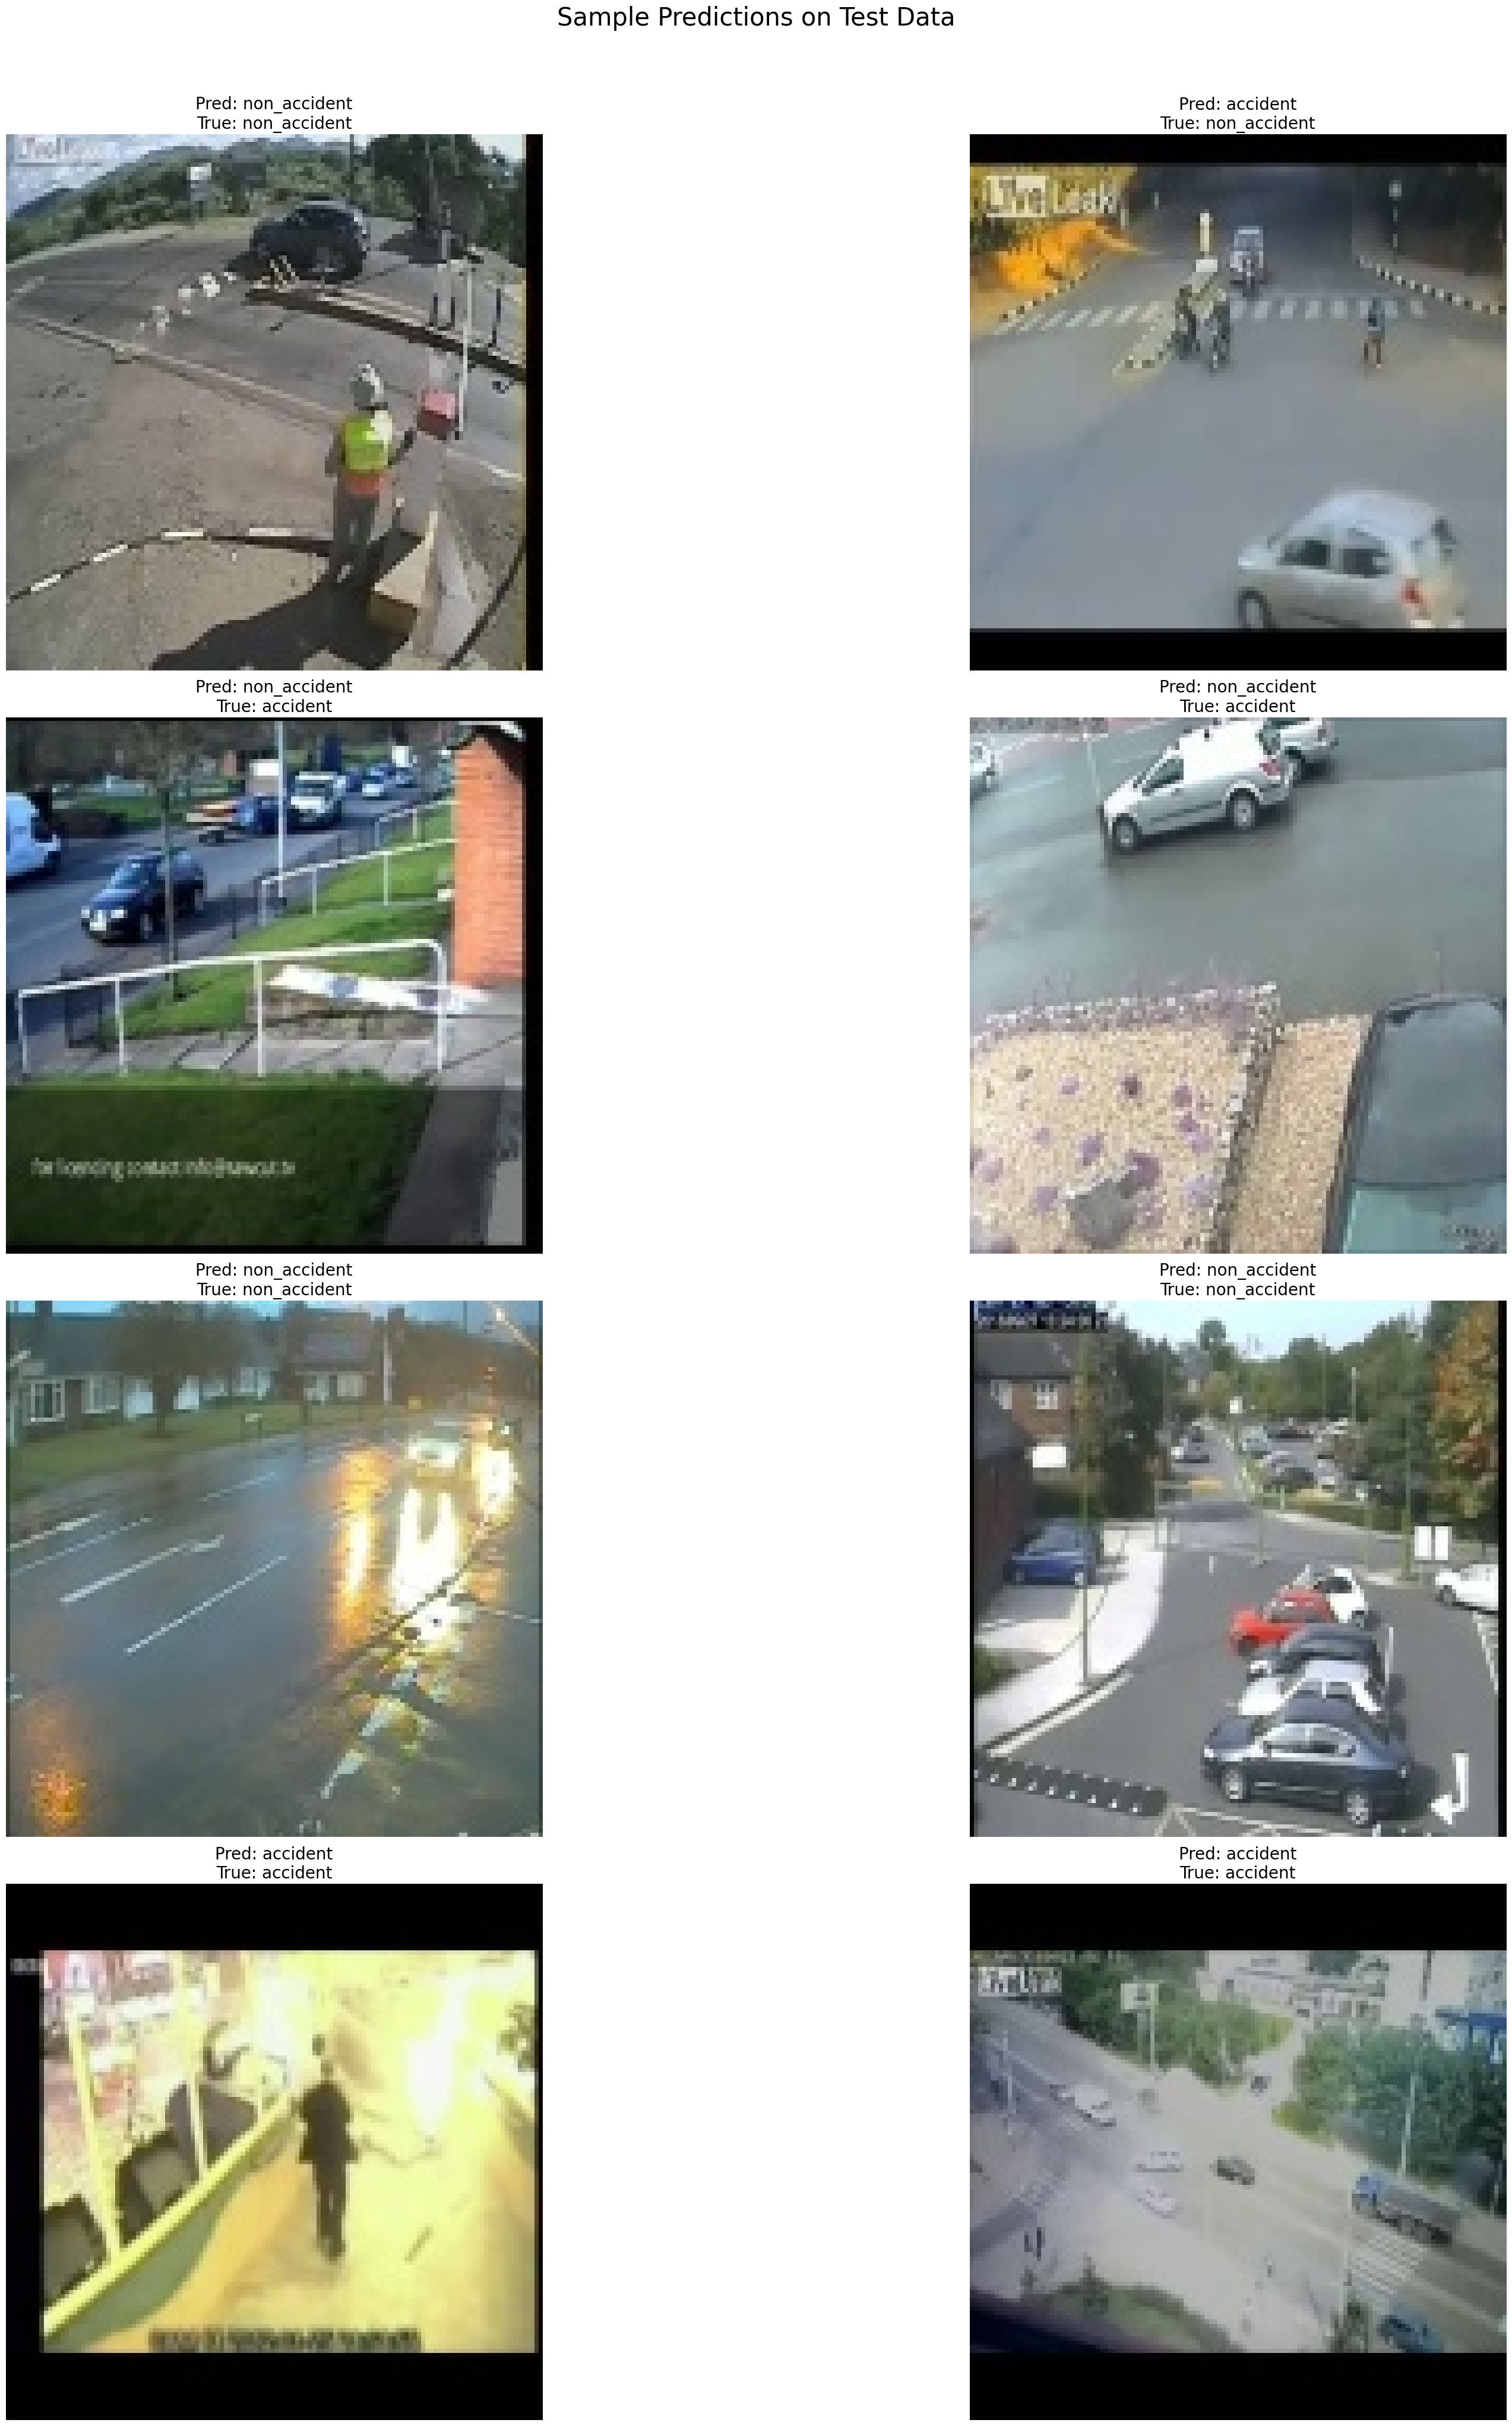

In [29]:
plt.figure(figsize=(40, 40))
num_samples = 8  # Number of samples to display
font_size = 20   # Set a larger font size for titles

for i in range(num_samples):
    # Get a random test sample
    idx = np.random.randint(0, len(X_test))
    clip = X_test[idx]
    true_label = y_test[idx]
    pred_label = y_pred_classes[idx][0]
    
    # Display a middle frame from the clip
    middle_frame = clip[len(clip)//2]
    
    ax = plt.subplot(4, 2, i + 1)
    plt.imshow(middle_frame)
    plt.title(f'Pred: {"accident" if pred_label else "non_accident"}\nTrue: {"accident" if true_label else "non_accident"}', fontsize=font_size)
    plt.axis('off')

plt.suptitle('Sample Predictions on Test Data', y=1.02, fontsize=30)  # Increase the font size for the main title
plt.tight_layout()
plt.savefig('sample_predictions.png')
plt.show()
